In [1]:
# Packages
import torch
import lightning as L
from torch.utils.data import TensorDataset, DataLoader
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import warnings

# Mymodel
from model.VAE import L_VAE_BCE as vae

In [4]:
# model setting
model = vae(input_dim=784, hidden_dim=200, latent_dim=20)
batch_size = 32
epochs = 50
log_every_n_step = 10

In [ ]:
# convert data to binary
warnings.filterwarnings('ignore')
column_names = ["label"] + [f"pixel{i}" for i in range(784)]

grey_train = pd.read_csv(
    "data\MNIST\mnist_train.csv", delimiter=",", names=column_names
)
grey_test = pd.read_csv("data\MNIST\mnist_test.csv", delimiter=",", names=column_names)

pixel_train = grey_train.drop(["label"], axis=1)  # avoid labels to be converted
pixel_test = grey_test.drop(["label"], axis=1)

binary_train = (pixel_train > 128).astype(int)
binary_test = (pixel_test > 128).astype(int)

binary_train = pd.concat([grey_train["label"], binary_train], axis=1, ignore_index=True)
binary_test = pd.concat([grey_test["label"], binary_test], axis=1, ignore_index=True)

binary_train.to_csv(
    "data\MNIST\mnist_binary_train.csv", index=False, header=column_names
)
binary_test.to_csv("data\MNIST\mnist_binary_test.csv", index=False, header=column_names)

In [ ]:
# import binary MNIST data
warnings.filterwarnings('ignore')
train_data = pd.read_csv("data\MNIST\mnist_binary_train.csv", delimiter=",")
test_data = pd.read_csv("data\MNIST\mnist_binary_test.csv", delimiter=",")

train_X = train_data.drop(["label"], axis=1)
train_y = train_data["label"]
test_X = test_data.drop(["label"], axis=1)
test_y = test_data["label"]

train_input = torch.FloatTensor(train_X.values)
train_label = torch.FloatTensor(train_y.values)
test_input = torch.FloatTensor(test_X.values)
test_label = torch.FloatTensor(test_y.values)

train_dataset = TensorDataset(train_input, train_label)
test_dataset = TensorDataset(test_input, test_label)

# dataloader
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:3: SyntaxWarning: invalid escape sequence '\M'
<>:2: SyntaxWarning: invalid escape sequence '\M'
<>:3: SyntaxWarning: invalid escape sequence '\M'
C:\Users\ice_8\AppData\Local\Temp\ipykernel_904\1767648824.py:2: SyntaxWarning: invalid escape sequence '\M'
  train_data = pd.read_csv("data\MNIST\mnist_binary_train.csv", delimiter=",")
C:\Users\ice_8\AppData\Local\Temp\ipykernel_904\1767648824.py:3: SyntaxWarning: invalid escape sequence '\M'
  test_data = pd.read_csv("data\MNIST\mnist_binary_test.csv", delimiter=",")


In [5]:
trainer = L.Trainer(max_epochs=epochs, log_every_n_steps=log_every_n_step)

# learning rate finder
tuner = L.pytorch.tuner.Tuner(trainer)
lr_find_results = tuner.lr_find(
    model,
    train_dataloaders=train_loader,
    min_lr=0.005,
    max_lr=1.0,
    early_stop_threshold=None,
)
new_lr = lr_find_results.suggestion()
model.learning_rate = new_lr
print(f"lr_find() suggest {new_lr:5f} for the learning rate.")
# train to fit
trainer.fit(model, train_dataloaders=train_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Ti Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Finding best initial lr: 100%|██████████| 100/100 [00:00<00:00, 189.49it/s]
Learning rate set to 0.009442643723643111
Restoring states from the checkpoint path at d:\Work repository\NN_test_build\.lr_find_1e661061-06f9-48fc-a417-bc3b3e56eee1.ckpt
Restored all states from the checkpoint at d:\Work repository\NN_test_build\.lr_find_1e661061-06f9-48fc-a417-bc3b3e56eee1.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params | Mode 
------------

lr_find() suggest 0.009443 for the learning rate.
Epoch 49: 100%|██████████| 1875/1875 [00:12<00:00, 151.73it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1875/1875 [00:12<00:00, 151.52it/s, v_num=2]


In [ ]:
# moniter loss with tensorboard
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/

loss stabilized around 2780 

In [14]:
# saving trained parameters
torch.save(model.state_dict(), "trained_parameters\L_VAE_MNIST.pt")

In [15]:
# load parameters into loaded_model
loaded_model = vae(input_dim=784, hidden_dim=200, latent_dim=20)
loaded_model.load_state_dict(torch.load("trained_parameters\L_VAE_MNIST.pt"))

<All keys matched successfully>

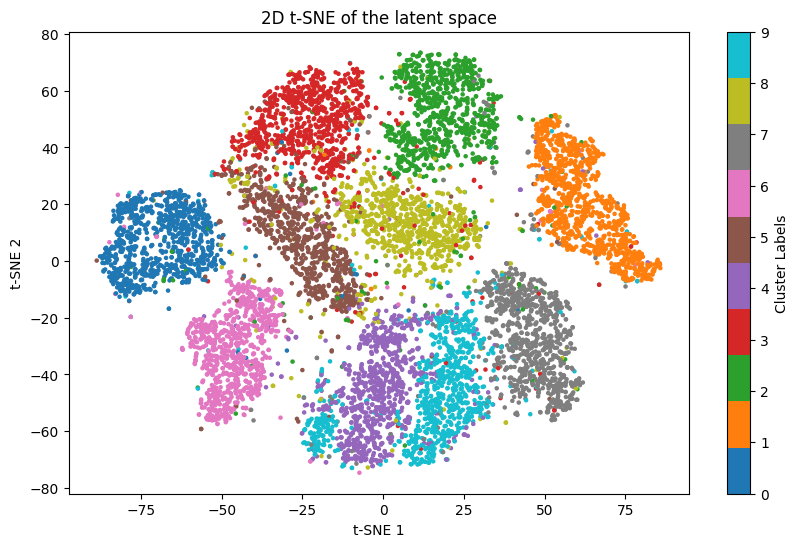

In [11]:
# plotting t_SNE for latent space with test dataset
def get_latent_space(model, data_loader):
    latent_vectors = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            mu, sigma = model.encoder(inputs.view(-1, 28 * 28))
            epsilon = torch.randn_like(sigma)
            z = mu + sigma * epsilon
            latent_vectors.append(z)
    return torch.cat(latent_vectors, dim=0).numpy()


# running t-SNE
latent_vectors = get_latent_space(loaded_model, test_loader)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init="pca")
tsne_features = tsne.fit_transform(latent_vectors)
plt.figure(figsize=(10, 6))
plt.scatter(
    tsne_features[:, 0],
    tsne_features[:, 1],
    s=20,
    marker=".",
    c=test_label,
    cmap="tab10",
)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("2D t-SNE of the latent space")
plt.colorbar(label="Cluster Labels")
plt.show()

distribution of 4 and 9 is partly convoluted 

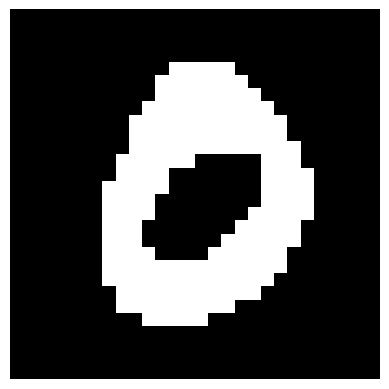

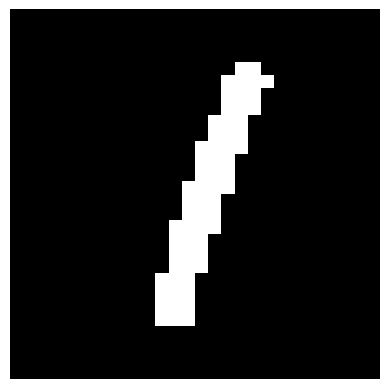

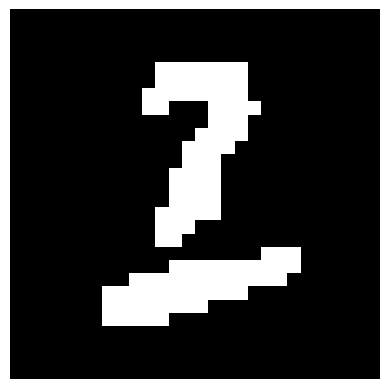

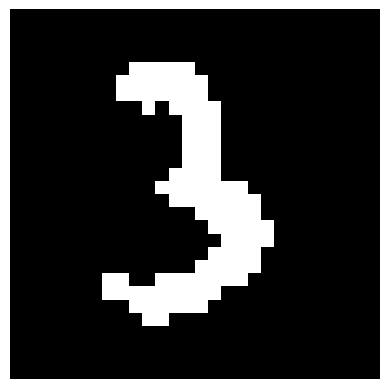

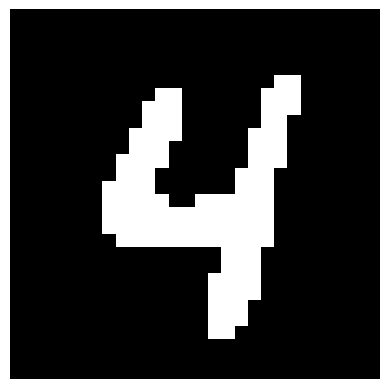

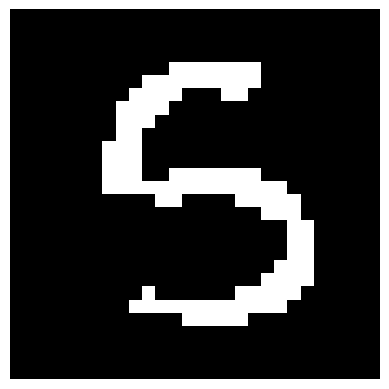

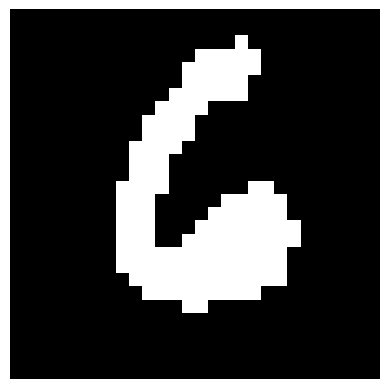

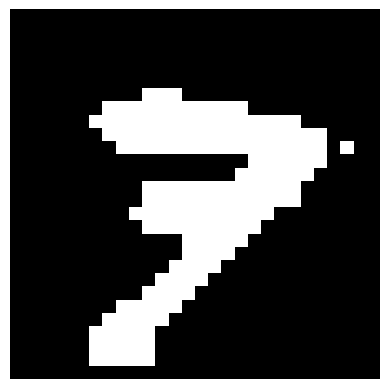

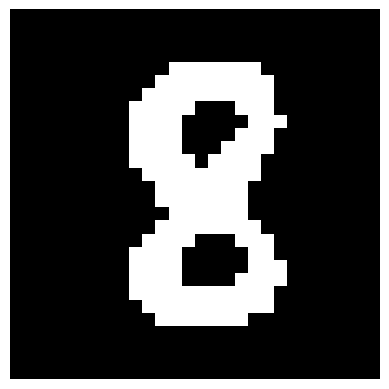

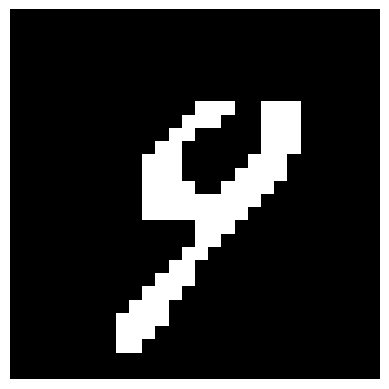

In [12]:
# generate image by sampling latent space 
def generate_image(model, dataset, label):
    images = []
    idx = label
    for x, y in dataset:
        if y == idx:
            images.append(x)

    encodeings_digit = []
    idx = label
    for idx in range(10):
        with torch.no_grad():
            mu, sigma = model.encoder(images[idx].view(1, 784))
            encodeings_digit.append((mu, sigma))

    mu, sigma = encodeings_digit[label]
    epsilon = torch.randn_like(sigma)
    z = mu + sigma * epsilon
    out = model.decoder(z)
    out = torch.where(out > 0.2, 1, 0)  # convert sigmoid output into binary
    out = out.view(1, 28, 28)  # generate image with 1 channel, 28 * 28 pixels
    out_np = out.cpu().numpy()
    out_np = np.transpose(out_np, (1, 2, 0))
    plt.imshow(out_np, cmap="gray")
    plt.axis("off")  # Hide axes
    plt.show()

# generate image 0-9
for i in range(10):
    generate_image(loaded_model, test_dataset, i)

9 is a bit similar to 4 (probably due to the distributions), but the result turns out alright

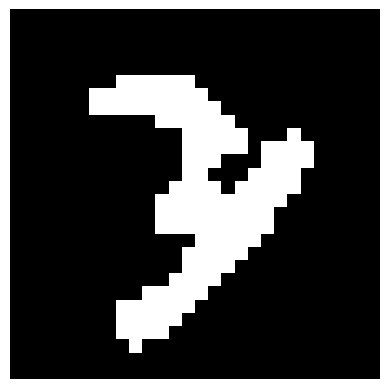

In [13]:
# generate mix image  (fooling around)
def generate_image_mix(model, dataset, label_1, label_2):
    images_1 = [] #sample latent space with label 1
    idx_1 = label_1
    for x, y in dataset:
        if y == idx_1:
            images_1.append(x)

    images_2 = []  #sample latent space with label 2
    idx_2 = label_2
    for x, y in dataset:
        if y == idx_2:
            images_2.append(x)

    encodeings_digit_1 = [] #get mu_1, sigma_1
    idx_1 = label_1
    for idx_1 in range(10):
        with torch.no_grad():
            mu_1, sigma_1 = model.encoder(images_1[idx_1].view(1, 784))
            encodeings_digit_1.append((mu_1, sigma_1))

    encodeings_digit_2 = [] #get mu_2, sigma_2
    idx_2 = label_2
    for idx_2 in range(10):
        with torch.no_grad():
            mu_2, sigma_2 = model.encoder(images_2[idx_2].view(1, 784))
            encodeings_digit_2.append((mu_2, sigma_2))

    mu_1, sigma_1 = encodeings_digit_1[label_1]
    mu_2, sigma_2 = encodeings_digit_2[label_2]
    mu = 0.5 * (mu_1 + mu_2) #takeing average to generate mu and sigma
    sigma = 0.5 * (sigma_1 + sigma_2)
    epsilon = torch.randn_like(sigma)
    z = mu + sigma * epsilon
    out = model.decoder(z)
    out = torch.where(out > 0.2, 1, 0)  # convert sigmoid output into binary
    out = out.view(1, 28, 28)  # generate image with 1 channel, 28 * 28 pixels
    out_np = out.cpu().numpy()
    out_np = np.transpose(out_np, (1, 2, 0))
    plt.imshow(out_np, cmap="gray")
    plt.axis("off")  # Hide axes
    plt.show()


generate_image_mix(loaded_model, test_dataset, 3, 7)